In [57]:
import geopandas as gpd
import pandas as pd

from shapely.ops import unary_union, linemerge
from shapely.geometry import Point, LineString, MultiLineString
from shapely.geometry import mapping

import json

from __future__ import annotations

from typing import Dict, Iterable, Optional
import numpy as np
import pandas as pd



import requests
import geopandas as gpd
from shapely.geometry import shape
import osm2geojson
from shapely.ops import unary_union, polygonize





### Berlin einlesen für Proof of concept

In [58]:
#net = gpd.read_file("../data/way_import.geojson")
net = gpd.read_parquet("processed_osm_files/processed_highways-width_berlin_251101.parquet")
len(net)

75868

In [59]:
wanted_highways = [
    "residential",
    "service",
    "secondary",
    "tertiary",
    "primary",
    "track",
    "unclassified",
    "secondary_link",
    "tertiary_link",
    "primary_link"
]
net_filtered = net[net["highway"].isin(wanted_highways)].copy()
len(net_filtered)

72908

In [60]:

net_filtered.columns = net_filtered.columns.str.replace('_', ':', regex=False)

In [69]:
"""
Compute effective carriageway width from OSM tags in a GeoDataFrame.

This module derives an "effective" road width that remains for motor traffic
(after subtracting on-carriageway parking lanes and on-carriageway cycle lanes)
using commonly mapped OSM tags. It is written to be robust against missing tags
and uses reasonable, documented defaults.

Expected columns (any subset; more is better):
  - width:carriageway, width, est_width
  - lanes, lanes:forward, lanes:backward
  - highway
  - parking:left, parking:right, parking:both
  - parking:left:orientation, parking:right:orientation
  - parking:left:position,    parking:right:position
  - parking:left:width,       parking:right:width
  - cycleway, cycleway:left, cycleway:right, cycleway:both
  - cycleway:width, cycleway:left:width, cycleway:right:width
  - oneway (optional; not required here)

Result columns added:
  - width_base               (float, meters)
  - parking_left_onlane_m    (float, meters)
  - parking_right_onlane_m   (float, meters)
  - cycleway_left_onlane_m   (float, meters)
  - cycleway_right_onlane_m  (float, meters)
  - width_effective          (float, meters, >= 0.0)

Usage:
    import geopandas as gpd
    from effective_width_geopandas import derive_effective_width

    gdf = gpd.read_file("edges.gpkg")
    gdf = derive_effective_width(gdf)
    # gdf["width_effective"] now contains the result in meters
"""


# ----------------------------- Defaults ------------------------------------ #

# Default values for width quality evaluations on shared roads
# Based on OSM Cycling Quality Index: https://github.com/SupaplexOSM/OSM-Cycling-Quality-Index
DEFAULT_WIDTH_TRAFFIC_LANE = 3.2        # average width of a driving lane (for common motor cars)
DEFAULT_WIDTH_BUS_LANE = 4.5            # average width of a bus/psv lane
DEFAULT_WIDTH_CYCLE_LANE = 1.4          # average width of a cycle lane
DEFAULT_WIDTH_PARKING_PARALLEL = 2.2    # average width of parallel parking
DEFAULT_WIDTH_PARKING_DIAGONAL = 4.5    # average width of diagonal parking
DEFAULT_WIDTH_PARKING_PERPENDICULAR = 5.0 # average width of perpendicular parking

# Default lane widths (meters) by highway class when we must estimate from lanes
# Using traffic lane width as base default
LANE_WIDTH_BY_HIGHWAY: Dict[str, float] = {
    # high-capacity roads
    "motorway": 3.75,
    "motorway_link": 3.75,
    "trunk": 3.75,
    "trunk_link": 3.75,
    # arterials
    "primary": 3.50,
    "primary_link": 3.50,
    "secondary": 3.50,
    "secondary_link": 3.50,
    # collectors / locals
    "tertiary": 3.25,
    "tertiary_link": 3.25,
    "unclassified": 3.25,
    "residential": 3.25,
    # narrow contexts
    "living_street": 3.00,
    "service": 3.00,
}
DEFAULT_LANE_WIDTH = DEFAULT_WIDTH_TRAFFIC_LANE  # Use standard traffic lane width

# Parking orientation -> typical width (meters)
# Based on OSM Cycling Quality Index defaults
PARKING_WIDTH_BY_ORIENTATION: Dict[str, float] = {
    "parallel": DEFAULT_WIDTH_PARKING_PARALLEL,
    "diagonal": DEFAULT_WIDTH_PARKING_DIAGONAL,
    "perpendicular": DEFAULT_WIDTH_PARKING_PERPENDICULAR,
}
DEFAULT_PARALLEL_PARKING_WIDTH = DEFAULT_WIDTH_PARKING_PARALLEL

# Fraction of the parking width that actually occupies the carriageway
# depending on the mapped "position" (street-parking schema).
PARKING_CARRIAGEWAY_FRACTION: Dict[str, float] = {
    "lane": 1.0,           # on carriageway
    "shoulder": 1.0,      # treat as occupying carriageway width
    "half_on_kerb": 0.5,  # half occupies carriageway
    "on_kerb": 0.0,       # fully on kerb/sidewalk → no subtraction
    "street_side": 0.0,   # bays next to carriageway → no subtraction
    "separate": 0.0,
    "no": 0.0,
}
DEFAULT_PARKING_POSITION = "lane"

# Default cycle lane width (meters) if a width tag is missing
# Based on OSM Cycling Quality Index default
DEFAULT_CYCLE_LANE_WIDTH = DEFAULT_WIDTH_CYCLE_LANE


# ----------------------------- Helpers ------------------------------------- #

def _coerce_float(series: Optional[pd.Series], index: Optional[pd.Index] = None) -> pd.Series:
    """Try to convert strings like '3.5', '3,5', '3.5 m' to float meters."""
    if series is None:
        # Return Series with proper index if provided, otherwise empty
        if index is not None:
            return pd.Series(index=index, dtype=float)
        return pd.Series(dtype=float)
    s = series.astype(str).str.strip()
    # Replace comma decimals, strip units
    s = (
        s.str.replace(",", ".", regex=False)
         .str.replace(" metres", "", regex=False)
         .str.replace(" meter", "", regex=False)
         .str.replace(" meters", "", regex=False)
         .str.replace(" m", "", regex=False)
    )
    out = pd.to_numeric(s, errors="coerce")
    return out


def _first_nonnull(*cols: Iterable[pd.Series]) -> pd.Series:
    """Return the first non-null among given series (aligned index)."""
    if not cols:
        raise ValueError("No columns provided")
    result = cols[0].copy()
    for s in cols[1:]:
        result = result.where(result.notna(), s)
    return result


def _lane_width_from_highway(hw: pd.Series) -> pd.Series:
    return hw.map(LANE_WIDTH_BY_HIGHWAY).fillna(DEFAULT_LANE_WIDTH)


def _sum_lanes(df: pd.DataFrame) -> pd.Series:
    """Get total lanes using lanes or lanes:forward + lanes:backward."""
    lanes_total = pd.to_numeric(df.get("lanes"), errors="coerce")
    lf = pd.to_numeric(df.get("lanes:forward"), errors="coerce")
    lb = pd.to_numeric(df.get("lanes:backward"), errors="coerce")
    lanes_fb = (lf.fillna(0) + lb.fillna(0))
    return lanes_total.fillna(lanes_fb).replace(0, np.nan)


def _parking_width_side(
    df: pd.DataFrame,
    side: str,
) -> pd.Series:
    """Compute parking width to subtract for one side (left/right).

    Subtract only the portion that lies on the carriageway (fraction by position).
    Priority of width sources:
        parking:<side>:width → else orientation default → default parallel width.
    Position default is assumed to be 'lane' when unknown.
    
    For highway=path, no default parking is assumed if no parking tags are present.
    """
    assert side in ("left", "right")

    # Get side-specific and both tags, handling missing columns
    p_base = df.get(f"parking:{side}")
    p_both = df.get("parking:both")
    
    # Handle case where column doesn't exist (returns None)
    if p_base is None:
        p_base = pd.Series(index=df.index, dtype=object)
    if p_both is None:
        p_both = pd.Series(index=df.index, dtype=object)
    
    # Combine side-specific and both tags
    base_val = p_base.where(p_base.notna(), p_both)

    # orientation and position
    orient = df.get(f"parking:{side}:orientation")
    if orient is None:
        orient = pd.Series(index=df.index, dtype=object)
    
    pos = df.get(f"parking:{side}:position")
    if pos is None:
        pos = pd.Series(index=df.index, dtype=object)

    # width as mapped (meters)
    width_tag = _coerce_float(df.get(f"parking:{side}:width"), index=df.index)

    # Check if highway=path and no parking tags are present
    highway = df.get("highway", pd.Series(index=df.index, dtype=object))
    has_parking_tags = base_val.notna() | width_tag.notna() | orient.notna() | pos.notna()
    is_path = highway == "path"
    
    # For highway=path, if no parking tags are present, return 0.0
    no_default_for_path = is_path & ~has_parking_tags

    # derive raw width by orientation default when width is missing
    orient_width = orient.map(PARKING_WIDTH_BY_ORIENTATION) if orient is not None else None
    if orient_width is None:
        orient_width = pd.Series(index=df.index, dtype=float)
    orient_width = orient_width.fillna(DEFAULT_PARALLEL_PARKING_WIDTH)

    raw_width = width_tag.where(width_tag.notna(), orient_width)
    
    # Set to 0.0 for path without parking tags
    raw_width = raw_width.where(~no_default_for_path, 0.0)

    # carriageway fraction from position / base tag
    frac_from_pos = pos.map(PARKING_CARRIAGEWAY_FRACTION) if pos is not None else None
    if frac_from_pos is None:
        frac_from_pos = pd.Series(index=df.index, dtype=float)

    # If explicit position is missing, infer from base tag value
    # Treat 'lane' as on-carriageway; 'street_side'/'separate' as off-carriageway
    inferred_frac = pd.Series(0.0, index=df.index)
    if base_val is not None and base_val.notna().any():
        inferred_frac = (
            base_val.replace({
                "lane": 1.0,
                "shoulder": 1.0,
                "half_on_kerb": 0.5,
                "on_kerb": 0.0,
                "street_side": 0.0,
                "separate": 0.0,
                "no": 0.0,
            }).infer_objects(copy=False)
        )
        # Any unknown strings become NaN → fill later
        inferred_frac = pd.to_numeric(inferred_frac, errors="coerce")

    frac = frac_from_pos.where(frac_from_pos.notna(), inferred_frac)
    # For path without parking tags, don't use default position
    default_frac = pd.Series(PARKING_CARRIAGEWAY_FRACTION.get(DEFAULT_PARKING_POSITION, 1.0), index=df.index)
    default_frac = default_frac.where(~no_default_for_path, 0.0)
    frac = frac.where(frac.notna(), default_frac)

    return (raw_width * frac).fillna(0.0)


def _cycle_lane_width_side(df: pd.DataFrame, side: str) -> pd.Series:
    """Cycle LANE width to subtract for one side (left/right).

    We subtract only when the mapping indicates an on-carriageway lane.
    Keys considered as on-carriageway: 'lane', 'share_busway'.
    'track' is off-carriageway and does not reduce carriageway width.
    """
    assert side in ("left", "right")

    # Side-specific value has priority over generic
    side_val = df.get(f"cycleway:{side}")
    both_val = df.get("cycleway:both")
    generic = df.get("cycleway")

    # Determine effective type for this side
    eff = side_val.copy() if side_val is not None else pd.Series(index=df.index, dtype=object)
    if both_val is not None:
        eff = eff.where(eff.notna(), both_val)
    if generic is not None:
        eff = eff.where(eff.notna(), generic)

    eff = eff.fillna("")

    # Width sources
    width_side = _coerce_float(df.get(f"cycleway:{side}:width"), index=df.index)
    width_both = _coerce_float(df.get("cycleway:width"), index=df.index)

    width_raw = width_side.where(width_side.notna(), width_both)
    width_raw = width_raw.fillna(DEFAULT_CYCLE_LANE_WIDTH)

    # Only subtract for on-carriageway types
    onlane_mask = eff.isin(["lane", "share_busway", "advisory"])
    # advisory bike lanes still occupy some width; we treat them like lanes

    return width_raw.where(onlane_mask, 0.0)


# --------------------------- Public API ------------------------------------ #

def derive_effective_width(
    gdf: "pd.DataFrame",
    *,
    lane_width_by_highway: Optional[Dict[str, float]] = None,
    default_lane_width: float = DEFAULT_LANE_WIDTH,
    parking_width_by_orientation: Optional[Dict[str, float]] = None,
    default_parallel_parking_width: float = DEFAULT_PARALLEL_PARKING_WIDTH,
    parking_carriageway_fraction: Optional[Dict[str, float]] = None,
    default_parking_position: str = DEFAULT_PARKING_POSITION,
    default_cycle_lane_width: float = DEFAULT_CYCLE_LANE_WIDTH,
    clamp_nonnegative: bool = True,
) -> "pd.DataFrame":
    """Add effective width columns to a (Geo)DataFrame of OSM ways.

    Neu:
      - width_base nimmt KEINE Lanes-Fallbacks mehr.
      - Zusätzliche Flag-Spalten:
          widths_missing, parking_missing, cycleway_missing
    """
    df = gdf.copy()

    # Allow overrides (bestehende Mechanik belassen)
    global LANE_WIDTH_BY_HIGHWAY, DEFAULT_LANE_WIDTH
    global PARKING_WIDTH_BY_ORIENTATION, DEFAULT_PARALLEL_PARKING_WIDTH
    global PARKING_CARRIAGEWAY_FRACTION, DEFAULT_PARKING_POSITION
    global DEFAULT_CYCLE_LANE_WIDTH

    if lane_width_by_highway is not None:
        LANE_WIDTH_BY_HIGHWAY = lane_width_by_highway
    DEFAULT_LANE_WIDTH = default_lane_width

    if parking_width_by_orientation is not None:
        PARKING_WIDTH_BY_ORIENTATION = parking_width_by_orientation
    DEFAULT_PARALLEL_PARKING_WIDTH = default_parallel_parking_width

    if parking_carriageway_fraction is not None:
        PARKING_CARRIAGEWAY_FRACTION = parking_carriageway_fraction
    DEFAULT_PARKING_POSITION = default_parking_position

    DEFAULT_CYCLE_LANE_WIDTH = default_cycle_lane_width

    # ---------------- 1) Basisbreite OHNE Lanes-Fallback --------------------
    width_carriageway = _coerce_float(df.get("width:carriageway"), index=df.index)
    width_total       = _coerce_float(df.get("width"), index=df.index)
    width_est         = _coerce_float(df.get("est_width"), index=df.index)

    width_base = _first_nonnull(width_carriageway, width_total, width_est)
    df["width_base"] = width_base

    # Flag: alle width-Felder fehlen → widths_missing
    df["widths_missing"] = (
        width_carriageway.isna() & width_total.isna() & width_est.isna()
    )

    # ---------------- 2) Parking-Abzug (bestehende Defaults) ----------------
    df["parking_left_onlane_m"]  = _parking_width_side(df, "left")
    df["parking_right_onlane_m"] = _parking_width_side(df, "right")

    # Flag: fehlen jegliche parking-* Tags auf beiden Seiten?
    def _has_parking_tags_side(side: str) -> pd.Series:
        base = df.get(f"parking:{side}")
        orient = df.get(f"parking:{side}:orientation")
        pos = df.get(f"parking:{side}:position")
        w = df.get(f"parking:{side}:width")
        return (
            (pd.Series(False, index=df.index) if base is None else base.notna()) |
            (pd.Series(False, index=df.index) if orient is None else orient.notna()) |
            (pd.Series(False, index=df.index) if pos is None else pos.notna()) |
            (pd.Series(False, index=df.index) if w is None else pd.to_numeric(w, errors="coerce").notna())
        )

    left_has  = _has_parking_tags_side("left")
    right_has = _has_parking_tags_side("right")
    both_has  = df.get("parking:both")
    both_has  = (pd.Series(False, index=df.index) if both_has is None else both_has.notna())

    df["parking_missing"] = ~(left_has | right_has | both_has)

    # ---------------- 3) Cycleway-Abzug (bestehende Defaults) ---------------
    df["cycleway_left_onlane_m"]  = _cycle_lane_width_side(df, "left")
    df["cycleway_right_onlane_m"] = _cycle_lane_width_side(df, "right")

    # Flag: fehlen jegliche cycleway*-Tags?
    def _series_notna(name: str) -> pd.Series:
        s = df.get(name)
        return pd.Series(False, index=df.index) if s is None else s.notna()

    df["cycleway_missing"] = ~(
        _series_notna("cycleway") |
        _series_notna("cycleway:left") |
        _series_notna("cycleway:right") |
        _series_notna("cycleway:both") |
        _series_notna("cycleway:width") |
        _series_notna("cycleway:left:width") |
        _series_notna("cycleway:right:width")
    )

    # ---------------- 4) Effektive Breite & Clipping ------------------------
    subtract_sum = (
        df[[
            "parking_left_onlane_m",
            "parking_right_onlane_m",
            "cycleway_left_onlane_m",
            "cycleway_right_onlane_m",
        ]]
        .sum(axis=1, min_count=1)
        .fillna(0.0)
    )

    df["width_effective"] = df["width_base"] - subtract_sum

    if clamp_nonnegative:
        df["width_effective"] = df["width_effective"].clip(lower=0.0)

    return df



# ------------------------------ Demo --------------------------------------- #
if __name__ == "__main__":
    # Minimal smoke test with pandas only (no geometry required)
    # demo = pd.DataFrame(
    #     [
    #         {"highway": "residential", "lanes": 2, "parking:left": "lane", "parking:left:orientation": "parallel"},
    #         {"width:carriageway": "7.0", "parking:right": "street_side"},
    #         {"width": "6,5 m", "cycleway:right": "lane", "cycleway:right:width": "1.8"},
    #         {"lanes:forward": 2, "lanes:backward": 1, "highway": "primary", "parking:left": "lane", "parking:left:orientation": "diagonal"},
    #     ]
    # )
    demo = derive_effective_width(net_filtered) #net_filtered
    with pd.option_context("display.max_columns", None):
        print(demo)


           osm:id      highway oneway lanes lanes:forward lanes:backward  \
0         4045150  residential   None  None          None           None   
1         4045194  residential   None  None          None           None   
2         4045220  residential   None  None          None           None   
3         4045223  residential    yes     1          None           None   
4         4045243      primary    yes     3          None           None   
...           ...          ...    ...   ...           ...            ...   
75863  1446740330    secondary    yes     2          None           None   
75864  1446740331    secondary    yes     2          None           None   
75865  1446765938      primary    yes     2          None           None   
75866  1446787374     tertiary   None     2          None           None   
75867  1446787375     tertiary   None     2          None           None   

      width width:carriageway est:width parking:left parking:right  \
0      None      

<Axes: >

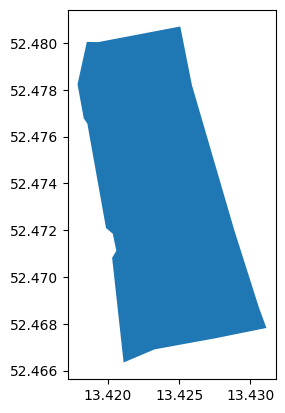

In [70]:
# get schillerkiez




# Deine Overpass-Query
query = """
[out:json][timeout:90];
area["name"="Berlin"]["boundary"="administrative"]->.berlin;

(
  rel(area.berlin)["name"="Schillerkiez"];
);

out body;
>;
out skel qt;
"""

# Anfrage an Overpass API
url = "https://overpass-api.de/api/interpreter"
response = requests.post(url, data={'data': query})
data = response.json()

# JSON -> GeoJSON
res_geojson = osm2geojson.json2geojson(data)

# GeoJSON -> GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(res_geojson["features"], crs="EPSG:4326")

gdf_schiller = gdf[gdf["type"]=="relation"]

# Alle Linien zu einer Geometrie vereinigen
merged_lines = unary_union(gdf_schiller.geometry)

# Versuche, daraus gültige Polygone zu bilden
polygons = list(polygonize(merged_lines))

# Nimm den größten (falls mehrere)
poly = max(polygons, key=lambda p: p.area)

gdf_schiller_poly = gpd.GeoDataFrame({"name": ["Schillerkiez"], "geometry": [poly]}, crs=gdf_schiller.crs)

gdf_schiller_poly.plot()

In [72]:
demo

,osm:id,highway,oneway,lanes,lanes:forward,lanes:backward,width,width:carriageway,est:width,parking:left,...,geometry,width_base,widths_missing,parking_left_onlane_m,parking_right_onlane_m,parking_missing,cycleway_left_onlane_m,cycleway_right_onlane_m,cycleway_missing,width_effective
0,4045150,residential,None,None,None,None,None,None,None,None,...,"LINESTRING (13.60524 52.37344, 13.60528 52.373...",NaN,True,2.2,2.2,True,0.0,0.0,False,NaN
1,4045194,residential,None,None,None,None,None,None,None,yes,...,"LINESTRING (13.53136 52.49263, 13.53136 52.492...",NaN,True,2.2,2.2,False,0.0,0.0,False,NaN
2,4045220,residential,None,None,None,None,None,None,None,None,...,"LINESTRING (13.52694 52.48969, 13.52676 52.489...",NaN,True,2.2,2.2,True,0.0,0.0,False,NaN
3,4045223,residential,yes,1,None,None,5,None,None,None,...,"LINESTRING (13.52477 52.48558, 13.52484 52.485...",5.0,False,2.2,2.2,False,0.0,0.0,False,0.6
4,4045243,primary,yes,3,None,None,None,None,None,None,...,"LINESTRING (13.4542 52.51571, 13.45431 52.5157...",NaN,True,0.0,0.0,False,0.0,0.0,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75863,1446740330,secondary,yes,2,None,None,None,None,None,None,...,"LINESTRING (13.34883 52.45913, 13.34881 52.459...",NaN,True,0.0,0.0,False,0.0,0.0,False,NaN
75864,1446740331,secondary,yes,2,None,None,None,None,None,None,...,"LINESTRING (13.34875 52.45939, 13.34874 52.45943)",NaN,True,0.0,0.0,False,0.0,0.0,False,NaN
75865,1446765938,primary,yes,2,None,None,None,None,None,no,...,"LINESTRING (13.4172 52.52169, 13.41789 52.52148)",NaN,True,0.0,2.2,False,0.0,4.0,False,NaN
75866,1446787374,tertiary,None,2,None,None,None,None,None,None,...,"LINESTRING (13.49927 52.51828, 13.4993 52.51875)",NaN,True,0.0,0.0,False,1.4,1.4,False,NaN


In [73]:

net_schiller = demo.clip(gdf_schiller_poly)


# Finde die 10 häufigsten Tags (basierend auf nicht-NaN-Werten)
# Exkludiere geometry und width_effective
exclude_cols = {'geometry', 'width_base', }
all_cols = [col for col in net_schiller.columns if col not in exclude_cols]

# Zähle nicht-NaN-Werte pro Spalte
non_null_counts = {col: net_schiller[col].notna().sum() for col in all_cols}

# Sortiere nach Häufigkeit und nimm die Top 10
top_6_tags = sorted(non_null_counts.items(), key=lambda x: x[1], reverse=True)[:6]
top_6_cols = [col for col, count in top_6_tags]

# Füge width_effective hinzu (falls es nicht schon dabei ist)
tooltip_cols = top_6_cols + ['parking_left_onlane_m', 'parking_right_onlane_m',
       'cycleway_left_onlane_m', 'cycleway_right_onlane_m', 'width_effective',"cycleway_missing","parking_missing","widths_missing"]
# Entferne Duplikate, falls width_effective schon in top_16_cols war
tooltip_cols = list(dict.fromkeys(tooltip_cols))

print(f"Tooltip Spalten ({len(tooltip_cols)}): {tooltip_cols}")
net_schiller.explore(column="width_effective", tooltip=tooltip_cols, tiles="CartoDB positron")

Tooltip Spalten (13): ['osm:id', 'highway', 'width', 'name', 'surface', 'widths_missing', 'parking_left_onlane_m', 'parking_right_onlane_m', 'cycleway_left_onlane_m', 'cycleway_right_onlane_m', 'width_effective', 'cycleway_missing', 'parking_missing']


/home/simon/nettobreite/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:2763: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: OGC:CRS84
Right CRS: EPSG:4326

  return geopandas.clip(self, mask=mask, keep_geom_type=keep_geom_type, sort=sort)


In [74]:

# Liste der gewünschten Spalten
wanted_cols = [ "osm:id", "geometry",
    "width:carriageway", "width", "est_width",
    "lanes", "lanes:forward", "lanes:backward",
    "highway",
    "parking:left", "parking:right", "parking:both",
    "parking:both:orientation", "parking:left:orientation", "parking:right:orientation",
    "parking:both:position", "parking:left:position", "parking:right:position",
    "parking:both:width", "parking:left:width", "parking:right:width",
    "cycleway", "cycleway:left", "cycleway:right", "cycleway:both",
    "cycleway:width", "cycleway:left:width", "cycleway:right:width",
    "oneway",
    # optional: die berechneten Ergebnis-Spalten
    "width_base", "parking_left_onlane_m", "parking_right_onlane_m",
    "cycleway_left_onlane_m", "cycleway_right_onlane_m",
    "width_effective",
    "cycleway_missing","parking_missing","widths_missing"
]
# Wenn df ein GeoDataFrame ist:
available = [c for c in wanted_cols if c in demo.columns]
demo_filtered = demo[available].copy()

In [75]:
demo_filtered

,osm:id,geometry,width:carriageway,width,lanes,lanes:forward,lanes:backward,highway,parking:left,parking:right,...,oneway,width_base,parking_left_onlane_m,parking_right_onlane_m,cycleway_left_onlane_m,cycleway_right_onlane_m,width_effective,cycleway_missing,parking_missing,widths_missing
0,4045150,"LINESTRING (13.60524 52.37344, 13.60528 52.373...",None,None,None,None,None,residential,None,None,...,None,NaN,2.2,2.2,0.0,0.0,NaN,False,True,True
1,4045194,"LINESTRING (13.53136 52.49263, 13.53136 52.492...",None,None,None,None,None,residential,yes,None,...,None,NaN,2.2,2.2,0.0,0.0,NaN,False,False,True
2,4045220,"LINESTRING (13.52694 52.48969, 13.52676 52.489...",None,None,None,None,None,residential,None,None,...,None,NaN,2.2,2.2,0.0,0.0,NaN,False,True,True
3,4045223,"LINESTRING (13.52477 52.48558, 13.52484 52.485...",None,5,1,None,None,residential,None,None,...,yes,5.0,2.2,2.2,0.0,0.0,0.6,False,False,False
4,4045243,"LINESTRING (13.4542 52.51571, 13.45431 52.5157...",None,None,3,None,None,primary,None,None,...,yes,NaN,0.0,0.0,0.0,0.0,NaN,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75863,1446740330,"LINESTRING (13.34883 52.45913, 13.34881 52.459...",None,None,2,None,None,secondary,None,None,...,yes,NaN,0.0,0.0,0.0,0.0,NaN,False,False,True
75864,1446740331,"LINESTRING (13.34875 52.45939, 13.34874 52.45943)",None,None,2,None,None,secondary,None,None,...,yes,NaN,0.0,0.0,0.0,0.0,NaN,False,False,True
75865,1446765938,"LINESTRING (13.4172 52.52169, 13.41789 52.52148)",None,None,2,None,None,primary,no,lane,...,yes,NaN,0.0,2.2,0.0,4.0,NaN,False,False,True
75866,1446787374,"LINESTRING (13.49927 52.51828, 13.4993 52.51875)",None,None,2,None,None,tertiary,None,None,...,None,NaN,0.0,0.0,1.4,1.4,NaN,False,False,True


In [76]:

demo_filtered.to_file("../data/berlin_nettobreite.fgb", driver="FlatGeobuf")

In [77]:
def fgb_to_pmtiles_dual_layer( polys_fgb, output_pmtiles, layer_name):
    import subprocess
    from pathlib import Path


    subprocess.run([
        "tippecanoe", "-o", str(Path(output_pmtiles).resolve()),
        f"--layer={layer_name}-lines",
        "--minimum-zoom=9", "--maximum-zoom=11",
        "--force",
        #"--simplify-only-low-zooms",
        #"--no-simplification-of-shared-nodes", "--simplification=200",
        "--no-feature-limit",  #"--maximum-tile-bytes=4000000", #"--force-feature-limit", "--no-tile-size-limit", 
        str(Path(polys_fgb).resolve())
    ], check=True)



    print("✅ Combined PMTiles created")


In [78]:
fgb_to_pmtiles_dual_layer(
    #points_fgb="scenario8_laerm_schulen_points.fgb",
    polys_fgb="../data/berlin_nettobreite.fgb",
    output_pmtiles="../data/berlin_nettobreite.pmtiles",
    layer_name="nettobreite"
    )

detected indexed FlatGeobuf: assigning feature IDs by sequence
72908 features, 5880859 bytes of geometry and attributes, 845183 bytes of string pool, 0 bytes of vertices, 0 bytes of nodes
tile 9/275/167 size is 610009 with detail 12, >500000    
tile 9/275/167 size is 530181 with detail 11, >500000    
tile 10/550/335 size is 614388 with detail 12, >500000    
tile 10/550/335 size is 569739 with detail 11, >500000    


✅ Combined PMTiles created


  95.4%  11/1100/671  
